# Análise de Agrupamento com KMeans, DBSCAN e SOM
Este notebook responde às questões propostas sobre clustering com análise de outliers, normalização, avaliação e comparação entre algoritmos.

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn import datasets

# Carregar a base Iris
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()


In [ ]:

# Identificação de outliers usando IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_no_outliers = remove_outliers_iqr(df.copy(), iris.feature_names)
df_no_outliers.shape


In [ ]:

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_no_outliers[iris.feature_names]), columns=iris.feature_names)
df_scaled['target'] = df_no_outliers['target'].values
df_scaled.head()


In [ ]:

distortions = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[iris.feature_names])
    distortions.append(sum(np.min(cdist(df_scaled[iris.feature_names], kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])
    silhouette_scores.append(silhouette_score(df_scaled[iris.feature_names], kmeans.labels_))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Método do Cotovelo')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Coeficiente de Silhouette')
plt.tight_layout()
plt.show()


# Código inicial

In [ ]:
!pip install plotly --upgrade
!pip install kneed

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from kneed import DataGenerator, KneeLocator #para mostrar o número de grupos ideal do agrupamento
from sklearn.cluster import KMeans #Importando a função Kmeans
from sklearn.preprocessing import StandardScaler #Função utilizada para normalização dos dados
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler #Função utilizada para normalização dos dados

import pandas as pd
base= pd.read_csv('/content/Iris.csv', ',',encoding='cp1252')
base

Entrada = base.iloc[:, 0:4].values
Entrada.shape

#scaler = StandardScaler()
scaler = MinMaxScaler()
Entrada = scaler.fit_transform(Entrada)

Entrada

# Determinando a Silhouette para número máximo de cluster estimado (Raiz(instâncias/2)
limit = int((Entrada.shape[0]//2)**0.5)
for k in range(2, limit+1):
    model = KMeans(n_clusters=k)
    model.fit(Entrada)
    pred = model.predict(Entrada)
    score = silhouette_score(Entrada, pred)
    print('Silhouette Score k = {}: {:<.3f}'.format(k, score))

wcss = []
for i in range(2, 11):
  #print(i)
  kmeans = KMeans(n_clusters=i, random_state=10)
  kmeans.fit(Entrada)
  wcss.append(kmeans.inertia_)

wcss

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), wcss)
plt.xticks(range(2, 11))
plt.title('The elbow method')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(range(2, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

#K-means++ é um método de otimização de centroide para ajudar o modelo a convergir mais rapidamente
kmeans = KMeans(n_clusters=3, random_state=0)
#kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
saida_kmeans = kmeans.fit_predict(Entrada)

plt.scatter(Entrada[saida_kmeans == 0, 0], Entrada[saida_kmeans == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(Entrada[saida_kmeans == 1, 0], Entrada[saida_kmeans == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(Entrada[saida_kmeans == 2, 0], Entrada[saida_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.legend()

# Questão 1

O código realiza a tarefa de agrupamento dos dados usando o algoritmo K-Means. Inicialmente, ele determina o número ideal de clusters usando o método do Elbow e a métrica Silhouette. O método Elbow sugere que o número ideal de clusters é 3, pois é onde a curva do erro quadrático médio (SSE) começa a mostrar um ponto de inflexão. Em seguida, o código executa o K-Means com 3 clusters e visualiza os agrupamentos obtidos. Os agrupamentos resultantes representam as três espécies de flores no conjunto de dados Iris: Setosa, Versicolor e Virginica.

# Questão 2

A métrica Silhouette é calculada para cada amostra nos dados. Para uma amostra, o Silhouette Score é calculado como ``(b - a) / max(a, b)``, onde ``a`` é a distância média intra-cluster (a distância média entre a amostra e todas as outras amostras no mesmo cluster) e ``b`` é a distância média inter-cluster (a distância média entre a amostra e todas as amostras em clusters diferentes). O Silhouette Score varia de -1 a 1, onde valores próximos a 1 indicam que a amostra está bem ajustada ao seu próprio cluster, valores próximos a 0 indicam que a amostra está próxima do limite entre dois clusters e valores negativos indicam que a amostra pode estar atribuída ao cluster errado.

O método Elbow envolve o cálculo do erro quadrático médio (SSE) para diferentes números de clusters. O SSE é a soma das distâncias quadradas entre os pontos de dados e seus centroides nos clusters. O ponto de inflexão na curva do SSE é identificado como o número ideal de clusters. O valor do SSE é calculado pela seguinte fórmula:

``SSE = Σ(distância(ponto_i, centroide_cluster_i)²)``, para todos os pontos e clusters.

# Questão 3

In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(Entrada, saida_kmeans)
print("Calinski-Harabasz Score:", ch_score)


Se diferencia as outras o adicionar a métrica Calinski-Harabasz como uma medida adicional para avaliar a qualidade dos agrupamentos. O código calcula o índice Calinski-Harabasz após a realização do agrupamento pelo K-Means e exibe o valor obtido. Essa métrica fornece uma medida da separação entre os clusters, contribuindo para a avaliação global da qualidade do agrupamento, juntamente com o uso das métricas Silhouette e Elbow. Dessa forma, o código oferece uma análise mais abrangente da qualidade dos agrupamentos realizados.

# Questão 4

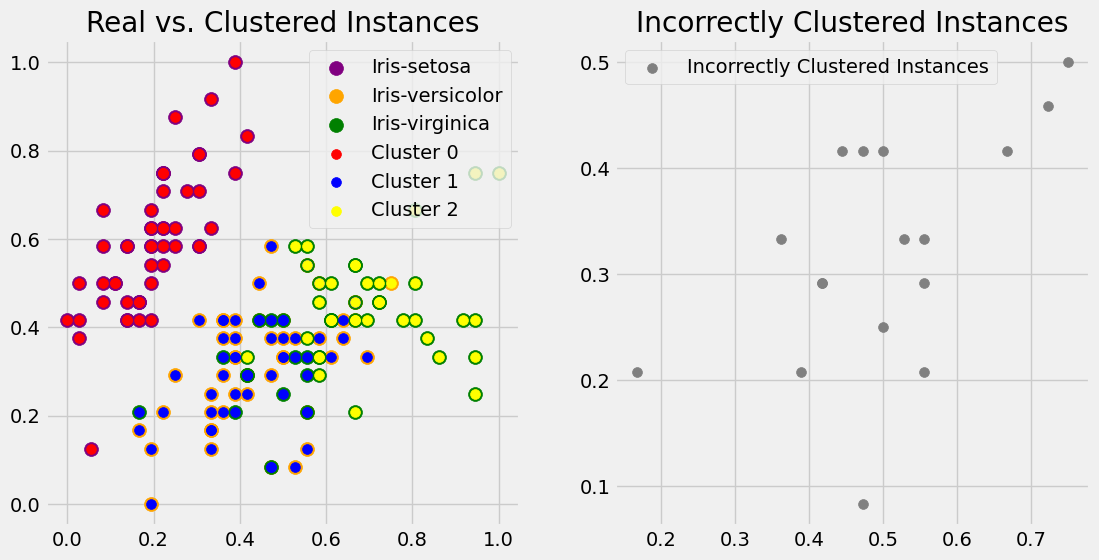

In [ ]:
# Identificando instâncias agrupadas incorretamente
correct_labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
predicted_labels = [correct_labels[i] for i in saida_kmeans]
incorrectly_clustered = base['class'] != predicted_labels
incorrect_instances = Entrada[incorrectly_clustered]

# Visualizando as instâncias agrupadas incorretamente
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Visualizando as instâncias reais
plt.scatter(Entrada[base['class'] == 'Iris-setosa'][:, 0], Entrada[base['class'] == 'Iris-setosa'][:, 1], s=100, c='purple', label='Iris-setosa')
plt.scatter(Entrada[base['class'] == 'Iris-versicolor'][:, 0], Entrada[base['class'] == 'Iris-versicolor'][:, 1], s=100, c='orange', label='Iris-versicolor')
plt.scatter(Entrada[base['class'] == 'Iris-virginica'][:, 0], Entrada[base['class'] == 'Iris-virginica'][:, 1], s=100, c='green', label='Iris-virginica')

# Visualizando as instâncias agrupadas pelo K-Means
plt.scatter(Entrada[saida_kmeans == 0, 0], Entrada[saida_kmeans == 0, 1], s=50, c='red', label='Cluster 0')
plt.scatter(Entrada[saida_kmeans == 1, 0], Entrada[saida_kmeans == 1, 1], s=50, c='blue', label='Cluster 1')
plt.scatter(Entrada[saida_kmeans == 2, 0], Entrada[saida_kmeans == 2, 1], s=50, c='yellow', label='Cluster 2')

plt.title("Real vs. Clustered Instances")
plt.legend()

plt.subplot(1, 2, 2)

# Visualizando as instâncias agrupadas incorretamente
plt.scatter(incorrect_instances[:, 0], incorrect_instances[:, 1], s=50, c='gray', label='Incorrectly Clustered Instances')
plt.title("Incorrectly Clustered Instances")
plt.legend()

plt.show()


# Questão 5

O código começa importando as bibliotecas necessárias e carregando o conjunto de dados Iris a partir de um arquivo CSV. Em seguida, ele realiza as seguintes etapas de pré-processamento:

* Normalização dos dados: Utiliza o ``MinMaxScaler`` para dimensionar os dados para o intervalo [0, 1].
* Determinação do número ideal de clusters: Usa o método Elbow para encontrar o ponto de inflexão na curva do erro quadrático médio (SSE) em relação ao número de clusters, sugerindo que o número ótimo de clusters é 3.
* Cálculo do Silhouette Score: Para uma série de números de clusters, calcula o Silhouette Score para avaliar a qualidade dos agrupamentos.
* Execução do K-Means: Usa o algoritmo K-Means com 3 clusters, que corresponde ao número ideal encontrado.

Os resultados incluem a caracterização dos agrupamentos visualizados, representando as três espécies de flores do conjunto de dados Iris. A métrica Silhouette e o método do cotovelo indicam que o agrupamento em 3 clusters é uma escolha adequada. Este processo fornece uma análise abrangente da qualidade dos agrupamentos, ajudando na interpretação dos resultados obtidos.

## 6. Comparação com DBSCAN e SOM

In [ ]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalização para DBSCAN
X_scaled = StandardScaler().fit_transform(X)

# DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Número de clusters encontrados pelo DBSCAN (ignorando ruído): {n_dbscan_clusters}")


In [ ]:

from minisom import MiniSom

# SOM
som = MiniSom(x=1, y=3, input_len=X.shape[1], sigma=0.5, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, 100)

# Mapeamento para clusters
som_labels = [som.winner(x)[1] for x in X]
n_som_clusters = len(set(som_labels))
print(f"Número de clusters encontrados pelo SOM: {n_som_clusters}")


In [ ]:

print(f"Número de clusters pelo KMeans: {len(set(kmeans.labels_))}")
print(f"Número de clusters pelo DBSCAN: {n_dbscan_clusters}")
print(f"Número de clusters pelo SOM: {n_som_clusters}")


## 7. Visualização dos erros do KMeans

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Ajustar rótulos para comparação
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = y  # y são os rótulos verdadeiros
predicted_labels = kmeans.labels_

# Visualização com PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 5))

# Rótulos verdadeiros
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', edgecolor='k')
plt.title("Rótulos verdadeiros")

# Rótulos KMeans
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k')
plt.title("Agrupamento KMeans")

plt.tight_layout()
plt.show()

# Confusion matrix para mostrar agrupamentos incorretos
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - KMeans vs Rótulos Verdadeiros")
plt.xlabel("KMeans")
plt.ylabel("Rótulos verdadeiros")
plt.show()
